# Reading and Processing Surface Water Data

Upon completing the data processing for GRACE and GLDAS, we will next shift our focus to the acquisition and analysis of surface water data. Surface water data is gathered via reservoir storage monitoring performed at designated monitoring sites for each reservoir. Contrasting with GRACE and GLDAS, surface water data is typically fragmented and region-specific.

This notebook guides you through the process of downloading and analyzing surface water data specific to the Colorado River Basin. The methodologies demonstrated here could be applied to other regions within the United States, given the broad coverage of our data sources. However, for more detailed data, regional websites and databases may prove beneficial. As for regions outside the United States, this notebook should serve as a useful springboard for scraping, processing, and visualizing surface water data.

Surface water data for the Colorado River Basin is distributed across several platforms including:
- [the Bureau of Reclamation](https://www.usbr.gov/uc/water/hydrodata/nav.html)(Reclamation)
- [the United States Geological Survey](https://waterdata.usgs.gov/nwis/sw)(USGS)
-[the US Army Corps of Engineers](https://resreg.spl.usace.army.mil/cgi-bin/slLatestBasin.cgi?gila+elev)
- [the Salt River Project Watershed Connection](https://streamflow.watershedconnection.com/?location=Apache%20Lake%20(Horse%20Mesa%20Dam)&project=undefined)

In this Jupyter Notebook, however, we will restrict our focus to data from the Reclamation and the USGS for the reasons detailed below:

- Research papers that study the groundwater in the Colorado River Basin frequently use data from Lake Powell and Lake Mead to represent the totality of surface water in the basin. This data is readily provided by the Reclamation and USGS.
- The data from the US Army Corps of Engineers only spans the most recent 180 days and that from the Salt River Project extends up to a year. Given our interest in the timeframe from 2002 to 2023 (the most recent year), the data from these two sources is insufficient.

As we progress through this notebook, you will be guided through the steps to download data from the Reclamation and USGS, clean and process this data, and finally visualize the distribution of monitoring sites and storage for reservoirs within the basin.

In [3]:
# Loading necessary packages
import csv
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point

import requests
from io import StringIO
from random import randint
from time import sleep
from requests.exceptions import RequestException
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

from fuzzywuzzy import fuzz
from datetime import date
from datetime import timedelta

import matplotlib.pyplot as plt

## Reading data from the Reclamation

The Reclamation hosted a [hydrologic database access portal](https://www.usbr.gov/uc/water/hydrodata/nav.html) for all relevent data on reservoirs they operated in the area of Colorado River Basin. The data we will be using are:
- a [metadata spreadsheet](https://www.usbr.gov/uc/water/hydrodata/reservoir_data/meta.csv) that include all the information about monitoring sites (latitude, longitude, site_id, etc)
- reservoir storage data for each monitoring site measured in acre feet


In [4]:
def read_reclamation_from_url(url):
    '''
    Scrape content from the Bureau of Reclamation website
    '''
    # Define a session for HTTP requests
    session = requests.Session()

    # Define the retry settings: total=5 will attempt the request up to 5 times
    # status_forcelist=[500, 502, 503, 504] will retry if one of these status codes is returned
    retries = Retry(total=5, backoff_factor=0.1, status_forcelist=[500, 502, 503, 504])

    # Mount the retry settings to the session
    session.mount("https://", HTTPAdapter(max_retries=retries))

    try:
        # Send the request and catch any exceptions
        response = session.get(url, timeout=10)
        
        # If the response was successful, parse it as CSV
        if response.status_code == 200:
            # Add a lag between each retrival (1 to 5 seconds) to make the attempt seems artificial
            sleep(randint(1,5))
            data = response.content.decode('utf-8')
            return pd.read_csv(StringIO(data))
        # If the response was unsuccessful, print the status code for response
        else:
            print(f"Failed to download file from {url}, status code: {response.status_code}")
            return None
    # If the request to scrape was unsuccessful, print the error message
    except RequestException as e:
        print(f"Failed to download file: {e}")
        return None

In [5]:
# Load CRB shapefile
basin_shape = gpd.read_file('/home/yhuang21/remoteData/shapefiles/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shp')

# Load reservoir data from Bureau of Reclamation
reclamation_reservoir_metadata = read_reclamation_from_url('https://www.usbr.gov/uc/water/hydrodata/reservoir_data/meta.csv') 

In [6]:
# Convert your DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(reclamation_reservoir_metadata['site_metadata.longi'], reclamation_reservoir_metadata['site_metadata.lat'])]
reservoirs_gdf = gpd.GeoDataFrame(reclamation_reservoir_metadata, geometry=geometry)

# Assign a Coordinate Reference System (CRS) to your GeoDataFrame. EPSG:4326 represents WGS 84 - Latitude/Longitude.
reservoirs_gdf.crs = "EPSG:4326"
basin_shape.crs = "EPSG:4326"

# Ensure that both GeoDataFrames have the same CRS before spatial join"
basin_shape = basin_shape.to_crs(reservoirs_gdf.crs)

# Perform spatial join so that only reservoirs inside the CRB shapefile will be selected
joined_gdf = gpd.sjoin(reservoirs_gdf, basin_shape, op='within')

# Filter by type_id (17 suggests the data is about reservoir storage) and select relevant columns
reclamation_reservoirs = joined_gdf[joined_gdf['datatype_id'] == 17][['site_metadata.lat', 'site_metadata.longi', 'site_metadata.site_name', 'site_id']]

/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [7]:
# Remove duplicate rows
reclamation_reservoirs = reclamation_reservoirs.drop_duplicates().reset_index(drop=True)

# Rename Columns
reclamation_reservoirs = reclamation_reservoirs.rename(columns={'site_metadata.site_name':'name', 'site_metadata.lat':'lat', 'site_metadata.longi':'lon'})
reclamation_reservoirs['name'] = reclamation_reservoirs['name'].str.title()

In [8]:
# Show the first 5 rows of the dataframe
reclamation_reservoirs.head()

,lat,lon,name,site_id
0,40.365100,-105.236000,Flatiron Reservoir Nr Loveland,100081
1,40.320000,-105.210000,Carter Lake,100065
2,40.600000,-105.170000,Horsetooth Reservoir,100091
3,39.878317,-106.329748,Green Mountain Reservoir,100089
4,39.366647,-106.458926,Homestake Reservoir,100120


In [12]:
# Check if reservoirs have more than one monitoring sites.
# We will keep only one monitoring site for each reservoir if the data from the monitoring sites are similar
if reclamation_reservoirs['name'].nunique() != len(reclamation_reservoirs):
    
    # Create a dictionary that stores reservoirs with more than one monitoring well
    repeated_reservoir = {}

    # Record the reservoir name and the row number where the record exists for such reservoir into a key value pair in a dictionary
    def collect_indexes(group):
        if len(group) > 1:
            repeated_reservoir[group.name] = group.index.tolist()
    
    # Check if each reservoir name has more than one monitoring sites
    reclamation_reservoirs.groupby('name').apply(collect_indexes)
    
    print(repeated_reservoir)
else:
    print("All reservoirs have only one monitoring site for each.")

{'Dillon Reservoir': [10, 45], 'Granby Reservoir': [5, 46], 'Green Mountain Reservoir': [3, 47], 'Shadow Mountain Reservoir': [7, 49, 52], 'Williams Fork Reservoir': [8, 50]}


/tmp/ipykernel_3867398/2631469203.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


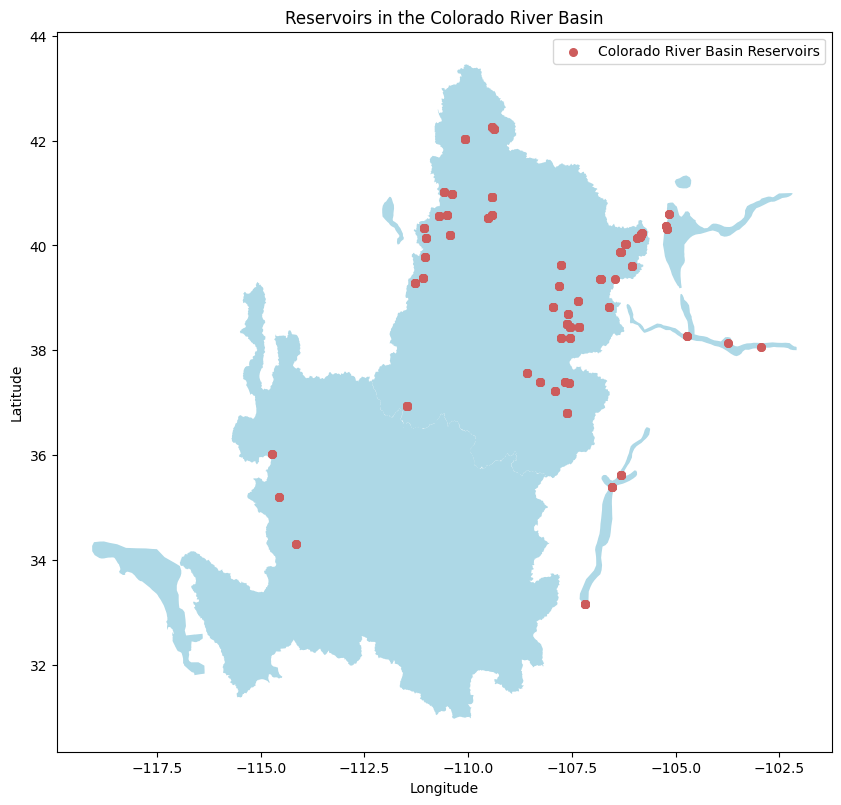

In [138]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the basins
basin_shape.plot(ax=ax, color='lightblue', label='Lower Basin')

# # Plot the reservoirs
joined_gdf.plot(ax=ax, marker='o', color='IndianRed', markersize=30, label='Colorado River Basin Reservoirs')

# # Add title and labels
plt.title('Reservoirs in the Colorado River Basin')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.legend()

# Show the plot
plt.show()


In [18]:
# URL link to each reservoir's storage data
reclamation_url_head = 'https://www.usbr.gov/uc/water/hydrodata/reservoir_data/'
reclamation_url_tail = '/csv/17.csv'

# Create an empty list to store all the temporary dataframes
data_list = []

# Iterate over each row in the reservoir dataframe to scrape the storage data at each monitoring site
for row in reclamation_reservoirs.itertuples(index=False):
    lat, lon, name, id = row
    # Scrape the website
    data = read_reclamation_from_url(reclamation_url_head + str(id) + reclamation_url_tail)

    # Calculate the monthly average storage for each site 
    data['datetime'] = pd.to_datetime(data['datetime'])
    data = data.set_index('datetime')
    data = data['storage'].resample('M').mean().reset_index()

    # Change the datetime input from YYYY-MM-DD to YYYY-MM
    data['datetime'] = data['datetime'].dt.to_period('M')

    # only selecting data from 2002 and onwards
    data = data[data['datetime'] >= '2002-01-01']

    # Add columns that documents the monitoring well's latitude, longitude, and name
    data['lat'] = lat
    data['lon'] = lon
    data['name'] = name

    #Store each dataframe of the monitoring sites into a list
    data_list.append(data)

In [15]:
# Initialize an empty list to store average storage for each reservoir with non-identical dataframes
average_storage_list = []
# Initialize an empty list to record indices of redundant rows
rows_to_be_deleted = []

for name, rows in repeated_reservoir.items():
    # Within each list of indices, compare consecutive pairs of potentially repeated dataframes
    non_identical_rows = []
    for i in range(len(rows)-1):
        # Check if the 'storage' column of two dataframes are identical
        if data_list[rows[i]]['storage'].equals(data_list[rows[i+1]]['storage']):
            # If they are identical, add the index of the latter dataframe to the list of redundant rows
            rows_to_be_deleted.append(rows[i+1])
        else:
            # If they are not identical, add the indices of the non-identical dataframes to the non_identical_rows list
            non_identical_rows.append(rows[i])
            non_identical_rows.append(rows[i+1])

            # Find the differences using the 'compare' method
            differences = data_list[rows[i]]['storage'].compare(data_list[rows[i+1]]['storage'])
            print(f"Different storage values found for {name} at indexes {rows[i]} and {rows[i+1]}:")
            print(differences) 

    # If there are non-identical dataframes for the reservoir, calculate the average storage
    if non_identical_rows:
        # Get the unique indices from non_identical_rows list as there might be duplicates
        non_identical_rows = list(set(non_identical_rows))

        # Get the dataframes using these indices and calculate their mean
        avg_storage = np.mean([data_list[i]['storage'].mean() for i in non_identical_rows])
        avg_lat = np.mean([data_list[i]['lat'].mean() for i in non_identical_rows])
        avg_lon = np.mean([data_list[i]['lon'].mean() for i in non_identical_rows])

        # Create a new DataFrame with the name, lat, lon, and average storage
        df = pd.DataFrame({'name': [name], 'lat': [avg_lat], 'lon': [avg_lon], 'average_storage': [avg_storage]})
        average_storage_list.append(df)
    else:
        print(name, ' is identical')

# Select only the dataframes that are not in the `rows_to_be_deleted` list
# data_list_clean = [df for i, df in enumerate(data_list) if i not in rows_to_be_deleted]

# # Concatenate the selected dataframes
# storage_df = pd.concat(data_list_clean, ignore_index=True)
# storage_df = storage_df[storage_df['datetime'] >= '2002-01-01']

# # Print the average storage for each reservoir with non-identical dataframes
# for name, avg in average_storage.items():
#     print(f"The average storage for {name} is {avg}")

Dillon Reservoir  is identical
Different storage values found for Granby Reservoir at indexes 5 and 46:
              self          other
836  369440.229871  369451.512903
854  484215.803333  484213.493333
Green Mountain Reservoir  is identical
Shadow Mountain Reservoir  is identical
Williams Fork Reservoir  is identical


In [23]:
if [5, 46]:
# Align dataframes by their index (already the date) and calculate their mean
    aligned_df = pd.concat([data_list[i] for i in [5,46]], axis=1)
    avg_storage = aligned_df.filter(like='storage').mean(axis=1)
    avg_storage.index = aligned_df['datetime'].iloc[:, 0]
    avg_storage = avg_storage.reset_index()
    avg_storage['name'] = name
    avg_storage['lat'] = lat



In [25]:
avg_storage

,datetime,0
0,2002-01,302820.096774
1,2002-02,276718.071429
2,2002-03,249718.225806
3,2002-04,234881.333333
4,2002-05,226370.451613
...,...,...
254,2023-03,407750.929032
255,2023-04,387251.803333
256,2023-05,429439.896774
257,2023-06,519864.316667


In [17]:
average_storage_list[0]

,name,lat,lon,average_storage
0,Granby Reservoir,40.170793,-105.86774,381925.458951


In [140]:
# Initialize an empty list to record indices of redundant rows
rows_to_be_deleted = []

for name, rows in repeated_reservoir.items():
    # Within each list of indices, compare consecutive pairs of potentially repeated dataframes
    for i in range(len(rows)-1):
        # Check if the 'storage' column of two dataframes are identical
        if data_list[rows[i]]['storage'].equals(data_list[rows[i+1]]['storage']):
            # If they are identical, add the index of the latter dataframe to the list of redundant rows
            rows_to_be_deleted.append(rows[i+1])
        else:
            # If they are not identical, find the differences using the 'compare' method
            differences = data_list[rows[i]]['storage'].compare(data_list[rows[i+1]]['storage'])
            print(f"Different storage values found for {name} at indexes {rows[i]} and {rows[i+1]}:")
            print(differences)

Different storage values found for GRANBY RESERVOIR at indexes 5 and 46:
              self          other
836  369440.229871  369451.512903
854  484215.803333  484213.493333
Different storage values found for WILLIAMS FORK RESERVOIR at indexes 8 and 50:
             self     other
216  96352.576923  96352.64


In [141]:
# The difference is not large for Granby Reservoir and the William, so we will only keep the data we obtained from the index 5 monitoring site
rows_to_be_deleted.append(46)

# Select only the dataframes that are not in the `rows_to_be_deleted` list
data_list_clean = [df for i, df in enumerate(data_list) if i not in rows_to_be_deleted]

# Concatenate the selected dataframes
storage_df = pd.concat(data_list_clean, ignore_index=True)
storage_df = storage_df[storage_df['datetime'] >= '2002-01-01']

In [142]:
storage_df

,datetime,storage,lat,lon,name
576,2002-01,531.967742,40.3651,-105.2360,Flatiron Reservoir nr Loveland
577,2002-02,574.607143,40.3651,-105.2360,Flatiron Reservoir nr Loveland
578,2002-03,575.967742,40.3651,-105.2360,Flatiron Reservoir nr Loveland
579,2002-04,551.000000,40.3651,-105.2360,Flatiron Reservoir nr Loveland
580,2002-05,569.903226,40.3651,-105.2360,Flatiron Reservoir nr Loveland
...,...,...,...,...,...
35661,2023-03,575989.258065,34.2964,-114.1385,Lake Havasu
35662,2023-04,574471.330000,34.2964,-114.1385,Lake Havasu
35663,2023-05,575608.451613,34.2964,-114.1385,Lake Havasu
35664,2023-06,576639.360000,34.2964,-114.1385,Lake Havasu


In [165]:
def read_usgs_from_url(url, is_metadata=False):
    response = requests.get(url)
    file_content = response.text

    if is_metadata:
        # Get the line number where data starts
        start_pos = file_content.index("site_no\tstation_nm\tsite_tp_cd\tdec_lat_va\tdec_long_va\tcoord_acy_cd\tdec_coord_datum_cd")
    else:
        start_pos = file_content.find("agency_cd\tsite_no\tdatetime\t")

    # Extract data from start line till end
    data_content = file_content[start_pos:]

    try:
        # Create a pandas dataframe
        df = pd.read_csv(StringIO(data_content), delimiter='\t')
        df = df.drop(0)
    except pd.errors.EmptyDataError:
        # No data to parse from the file, return None
        return None

    if is_metadata:
        # Select only the columns of interest
        df = df[['dec_lat_va', 'dec_long_va','station_nm','site_no']]
        df['station_nm'] = df['station_nm'].str.title()
        df = df.rename(columns={'site_no':'site_id', 'station_nm':'name', 'dec_lat_va':'lat', 'dec_long_va':'lon'})
    else:
         # Extract columns of the format 'ddddd_00054_ddddd' (any length of d)
        pattern = r'^\d+_00054_\d+$'  # regex pattern to match the desired column format
        matched_columns = df.filter(regex=pattern).columns

        # Specify the order of columns you're interested in
        column_order = ['00003', '32400', '30800', '00011']

        # Select the first column that exists in the DataFrame according to your order
        for end_digits in column_order:
            column_name = next((col for col in matched_columns if col.endswith(end_digits)), None)
            if column_name:
                df = df[['datetime', column_name]]
                df = df.rename(columns={column_name: 'storage'})
                df.replace('NaN', np.nan, inplace=True)
                df['storage'] = pd.to_numeric(df['storage'], errors='coerce')
                break

    return df


In [164]:
reclamation_reservoirs

,lat,lon,name,site_id
0,40.365100,-105.236000,Flatiron Reservoir nr Loveland,100081
1,40.320000,-105.210000,Carter Lake,100065
2,40.600000,-105.170000,Horsetooth Reservoir,100091
3,39.878317,-106.329748,GREEN MOUNTAIN RESERVOIR,100089
4,39.366647,-106.458926,HOMESTAKE RESERVOIR,100120
...,...,...,...,...
57,35.628230,-106.317160,COCHITI LAKE,2696
58,35.394720,-106.544720,JEMEZ CANYON RESERVOIR,2744
59,36.016300,-114.737400,Lake Mead,921
60,35.197900,-114.569400,Lake Mohave,922


In [167]:
usgs_reservoirs = read_usgs_from_url('https://waterdata.usgs.gov/nwis/dv?referred_module=sw&search_site_no=09&search_site_no_match_type=beginning&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd=LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&index_pmcode_00054=1&group_key=county_cd&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=site_tp_cd&column_name=dec_lat_va&column_name=dec_long_va&range_selection=days&period=365&date_format=YYYY-MM-DD&rdb_compression=file&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection', is_metadata=True)

usgs_reservoirs['lat'] = usgs_reservoirs['lat'].astype(float)
usgs_reservoirs['lon'] = usgs_reservoirs['lon'].astype(float)

# Define function to clean station name
def clean_station_name(name):
    for separator in [" Near ", " At "]:
        name = name.split(separator)[0]
    return name

# Apply function to 'station_nm' column
usgs_reservoirs['name'] = usgs_reservoirs['name'].apply(clean_station_name)

In [170]:
# Initialize an empty list to hold the indices of rows to drop
rows_to_drop = []

# Iterate over each row in usgs_reservoirs
for i, row in usgs_reservoirs.iterrows():
    lat, lon, usgs_name = row['lat'], row['lon'], row['name'].lower()
    
    # Find rows in reservoirs where lat and lon are within the threshold
    mask = ((reclamation_reservoirs['lat'] - lat).abs() < 0.05) & ((reclamation_reservoirs['lon'] - lon).abs() < 0.05)
    
    # Compare names using fuzzywuzzy
    for j, row_res in reclamation_reservoirs[mask].iterrows():
        print("---------")
        print('Name from USGS:', usgs_name)
        reclamation_name = row_res['name'].lower()
        print('Name from Reclamation:', reclamation_name)
        score = fuzz.ratio(usgs_name, reclamation_name)
        print('Similarity score', score)
        if score > 90 or reclamation_name in usgs_name:
            rows_to_drop.append(i)
            break

# Drop duplicates from usgs_reservoirs
usgs_reservoirs = usgs_reservoirs.drop(rows_to_drop)
usgs_reservoirs = usgs_reservoirs.reset_index(drop=True)

---------
Name from USGS: rifle gap reservoir
Name from Reclamation: rifle gap reservoir
Similarity score 100
---------
Name from USGS: vega reservoir
Name from Reclamation: vega reservoir
Similarity score 100
---------
Name from USGS: taylor park reservoir
Name from Reclamation: taylor park reservoir
Similarity score 100
---------
Name from USGS: silver jack reservoir
Name from Reclamation: silver jack reservoir
Similarity score 100
---------
Name from USGS: crawford reservoir
Name from Reclamation: crawford reservoir
Similarity score 100
---------
Name from USGS: paonia reservoir
Name from Reclamation: paonia reservoir
Similarity score 100
---------
Name from USGS: fruit growers reservoir
Name from Reclamation: fruitgrowers reservoir
Similarity score 98
---------
Name from USGS: ridgway reservoir
Name from Reclamation: ridgway reservoir
Similarity score 100
---------
Name from USGS: big sandy reservoir
Name from Reclamation: big sandy reservoir
Similarity score 100
---------
Name fro

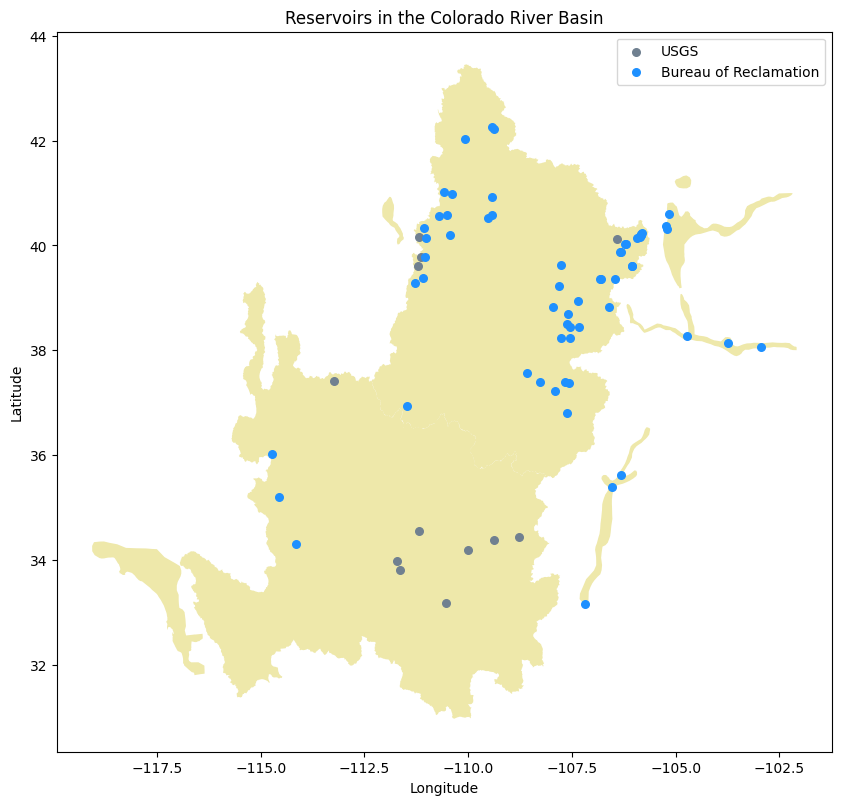

In [204]:
usgs_reservoirs['source'] = 'USGS'
reclamation_reservoirs['source'] = 'Bureau of Reclamation'
all_reservoirs_info = pd.concat([usgs_reservoirs, reclamation_reservoirs]).reset_index(drop=True)

# Convert your DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(all_reservoirs_info['lon'], all_reservoirs_info['lat'])]
all_reservoirs_gdf = gpd.GeoDataFrame(all_reservoirs_info, geometry=geometry)
all_reservoirs_gdf.crs = "EPSG:4326"

usgs_reservoirs_gdf = all_reservoirs_gdf[all_reservoirs_gdf['source'] == 'USGS']
reclamation_reservoirs_gdf = all_reservoirs_gdf[all_reservoirs_gdf['source'] == 'Bureau of Reclamation']

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the basins
basin_shape.plot(ax=ax, color='palegoldenrod')

# Plot the reservoirs
usgs_reservoirs_gdf.plot(ax=ax, marker='o', color='slategrey', markersize=30, label='USGS')
reclamation_reservoirs_gdf.plot(ax=ax, marker='o', color='dodgerblue', markersize=30, label='Bureau of Reclamation')

# Add title, labels, and legend
plt.title('Reservoirs in the Colorado River Basin')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.legend()

# Show the plot
plt.show()


In [179]:
all_reservoirs_info

,lat,lon,name,site_id
0,40.112763,-106.415032,"Wolford Mtn Reservoir Nr Kremmling, Co",09041395
1,40.169400,-111.179893,"Strawberry Reservoir Nr Soldier Springs, Utah",09282500
2,39.787461,-111.125726,Scofield Reservoir,09311000
3,39.600797,-111.212118,Electric Lake,09317800
4,34.374484,-109.384818,Lyman Lake,09384600
...,...,...,...,...
69,35.628230,-106.317160,COCHITI LAKE,2696
70,35.394720,-106.544720,JEMEZ CANYON RESERVOIR,2744
71,36.016300,-114.737400,Lake Mead,921
72,35.197900,-114.569400,Lake Mohave,922


xxxx_00054_32400:observation at midnight
xxxx_00054_00011: (Instantaneous)
xxxx_00054_00003: mean
xxxx_00054_30800: observation at 8 am

In [149]:
# URL link to each reservoir's storage data
usgs_url_head = 'https://waterdata.usgs.gov/nwis/dv?cb_00054=on&format=rdb&site_no='
yesterday = date.today() - timedelta(days = 1)
usgs_url_tail = '&legacy=&referred_module=sw&period=&begin_date=2002-01-01&end_date=' + str(yesterday)

# Create an empty list to store all the temporary dataframes
data_list = []

# Iterate over each row in the reservoir dataframe to scrape the storage data at each monitoring site
for row in usgs_reservoirs.itertuples(index=False):
    id, name, lat, lon = row
    data = read_usgs_from_url(usgs_url_head + str(id) + usgs_url_tail)
    if data is not None:
        data['datetime'] = pd.to_datetime(data['datetime'])
        data = data.set_index('datetime')

        # # Calculate the monthly average storage for each site
        data = data['storage'].resample('M').mean().reset_index()
        data['datetime'] = data['datetime'].dt.to_period('M')
        data['lat'] = lat
        data['lon'] = lon
        data['name'] = name

        #Store each dataframe of the monitoring sites into a list
        data_list.append(data)

WOLFORD MTN RESERVOIR NR KREMMLING, CO
STRAWBERRY RESERVOIR NR SOLDIER SPRINGS, UTAH
SCOFIELD RESERVOIR
ELECTRIC LAKE
LYMAN LAKE
ZUNI SALT LAKE NR QUEMADO, NM
SHOW LOW LAKE
CRAGIN DAM RESERVOIR
ASH CREEK RESERVOIR
SAN CARLOS RESERVOIR
HORSESHOE RESERVOIR
BARTLETT RESERVOIR


In [150]:
# suppose your list of dataframes is df_list
data_list.append(storage_df)  # append the storage_df to the list
storage_df = pd.concat(data_list, ignore_index=True)


In [151]:
storage_df

,datetime,storage,lat,lon,name
0,2004-10,30916.129032,40.112763,-106.415032,"WOLFORD MTN RESERVOIR NR KREMMLING, CO"
1,2004-11,29102.666667,40.112763,-106.415032,"WOLFORD MTN RESERVOIR NR KREMMLING, CO"
2,2004-12,28685.483871,40.112763,-106.415032,"WOLFORD MTN RESERVOIR NR KREMMLING, CO"
3,2005-01,28518.709677,40.112763,-106.415032,"WOLFORD MTN RESERVOIR NR KREMMLING, CO"
4,2005-02,28287.142857,40.112763,-106.415032,"WOLFORD MTN RESERVOIR NR KREMMLING, CO"
...,...,...,...,...,...
16346,2023-03,575989.258065,34.296400,-114.138500,Lake Havasu
16347,2023-04,574471.330000,34.296400,-114.138500,Lake Havasu
16348,2023-05,575608.451613,34.296400,-114.138500,Lake Havasu
16349,2023-06,576639.360000,34.296400,-114.138500,Lake Havasu


In [153]:
# Define the bin size
bin_size = 0.25

# Bin the latitude and longitude data and calculate the midpoint
storage_df['lat'] = (np.floor(storage_df['lat'] / bin_size) * bin_size) + bin_size / 2
storage_df['lon'] = (np.floor(storage_df['lon'] / bin_size) * bin_size) + bin_size / 2

# convert unit from acre-feet to cubic kilometer
storage_df['storage'] = storage_df['storage'] * 0.000001233

In [ ]:
# Convert your DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(reclamation_reservoir_metadata['site_metadata.longi'], reclamation_reservoir_metadata['site_metadata.lat'])]
reservoirs_gdf = gpd.GeoDataFrame(reclamation_reservoir_metadata, geometry=geometry)
reservoirs_gdf.crs = "EPSG:4326"

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the basins
reservoirs_gdf.plot(ax=ax, color='lightblue', label='Lower Basin')

# # Plot the reservoirs
reservoirs_gdf.plot(ax=ax, marker='o', color='IndianRed', markersize=30, label='Colorado River Basin Reservoirs')

# # Add title and labels
plt.title('Reservoirs in the Colorado River Basin')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.legend()

# Show the plot
plt.show()

In [163]:
usgs_reservoirs

,site_no,station_nm,dec_lat_va,dec_long_va
0,09041395,"WOLFORD MTN RESERVOIR NR KREMMLING, CO",40.112763,-106.415032
1,09282500,"STRAWBERRY RESERVOIR NR SOLDIER SPRINGS, UTAH",40.169400,-111.179893
2,09311000,SCOFIELD RESERVOIR,39.787461,-111.125726
3,09317800,ELECTRIC LAKE,39.600797,-111.212118
4,09384600,LYMAN LAKE,34.374484,-109.384818
5,09386189,"ZUNI SALT LAKE NR QUEMADO, NM",34.448881,-108.768386
6,09391000,SHOW LOW LAKE,34.195876,-110.004831
7,09398300,CRAGIN DAM RESERVOIR,34.555304,-111.184025
8,09406600,ASH CREEK RESERVOIR,37.410536,-113.235505
9,09469000,SAN CARLOS RESERVOIR,33.175616,-110.527878


In [162]:
usgs_reservoirs['station_nm'] = usgs_reservoirs['station_nm'].str.title()

KeyError: 'name'

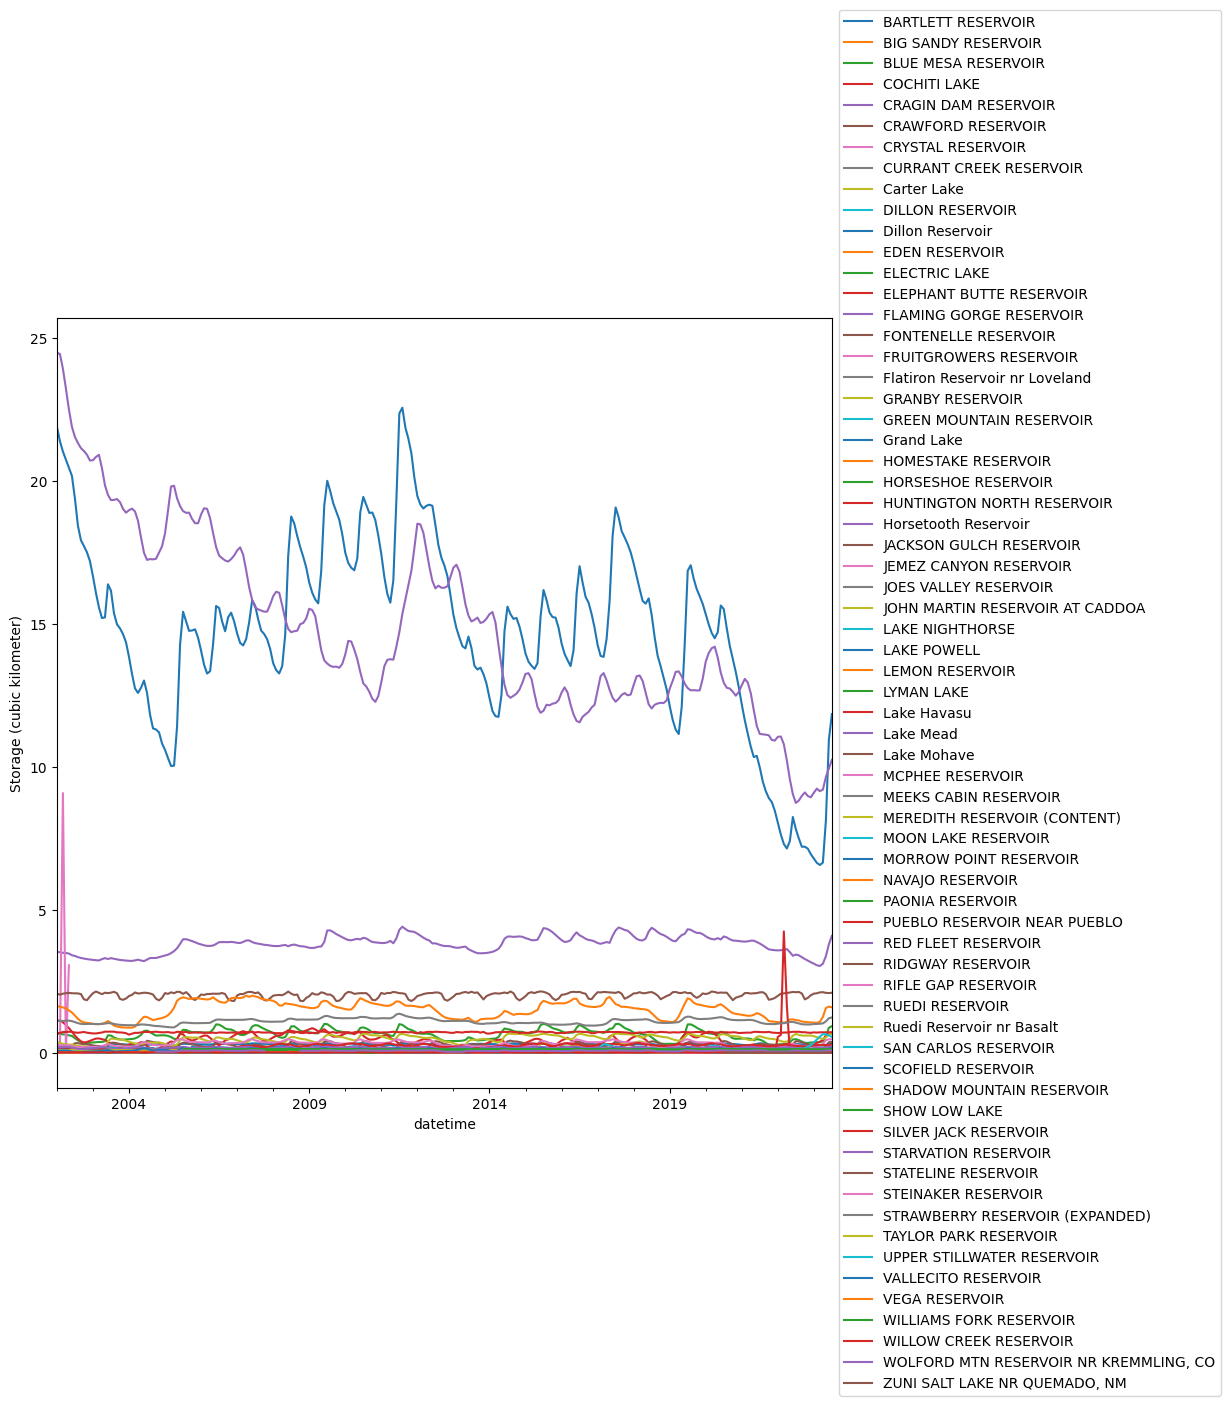

In [154]:
# Create a new figure
plt.figure(figsize=(10, 10))

# Iterate over the reservoir groups and plot each one
for name, group in storage_df.groupby('name'):
    group.plot(x='datetime', y='storage', label=name, ax=plt.gca())

# Display the legend and show the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Storage (cubic kilometer)')
plt.show()

In [156]:
storage_df.to_csv('reservoir_storage.csv', index=False)